# STA 141A Project
#### Project milestone 1
Name: Soha Ahmed<br>
Student ID: 922437030<br>


## Predicting Decision Outcomes in Mice Using Neural Spike Train Data

### Abstract:
In this project, we aim to build a predictive model that will be helpful for classification of trial outcomes (success or failure). This predictive model will be based on neural activity data from visual discrimination tasks performed by mice. The dataset consists of spike train recordings from neurons in the visual cortex along with trial stimuli conditions (left and right contrast levels). The study is structured into three parts: exploratory data analysis (EDA), data integration, and model development. We will test this on various machine learning models to determine which is the most efficient predictor of them all. 

### 1. Introduction:
* Brief overview of Steinmetz et al. (2019) study.
* Importance of understanding neural activity in decision-making.
* Goals: Extract insights from neural spike train data and improve predictive accuracy of trial outcomes.

Inspecting the file

In [6]:
import rpy2.robjects as robjects
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [8]:
# Define the path to the data folder
data_path = r"C:\Users\arshi\OneDrive\Desktop\Soha\STA 141A\STA 141A project\Data"

# Function to read RDS file
def read_rds(file_path):
    readRDS = robjects.r['readRDS']
    return readRDS(file_path)

# load all sessions
sessions = []
for i in range(1, 19):
    file_name = f'session{i}.rds'
    file_path = os.path.join(data_path, file_name)
    session_data = read_rds(file_path)
    sessions.append(session_data)

In [9]:
# Initialize a list to store session summaries
session_summaries = []

# Process each session
for i in sessions:
    # Extract session metadata
    mouse_name = i.rx2('mouse_name')[0]
    date_exp = i.rx2('date_exp')[0]
    
    # Extract neural data
    spks = i.rx2('spks')  # Spike trains (list of matrices)
    # Convert R matrix to numpy array for the first trial
    first_trial_spks = np.array(spks[0])
    n_neurons = first_trial_spks.shape[0]  # Number of neurons (rows in the spike matrix)
    n_trials = len(spks)  # Number of trials (length of the list)
    # Extract feedback data
    feedback_type = np.array(i.rx2('feedback_type'))  # Feedback type (1 or -1)
    success_rate = np.mean(feedback_type == 1)  # Success rate
    
    # Extract brain area data
    brain_area = np.array(i.rx2('brain_area'))  # Convert to numpy array
    n_brain_area = len(np.unique(brain_area))  # Number of unique brain areas
    
    # Append session summary to the list
    session_summaries.append({
        "mouse_name": mouse_name,
        "date_exp": date_exp,
        "n_brain_area": n_brain_area,
        "n_neurons": n_neurons,
        "n_trials": n_trials,
        "success_rate": success_rate
    })

# Convert to DataFrame for easier analysis
session_summary_df = pd.DataFrame(session_summaries)

In [12]:
# Convert to DataFrame for easier analysis
session_summary_df = pd.DataFrame(session_summaries)

In [14]:
print(dict(session_data.items()))

{'contrast_left': <rpy2.robjects.vectors.FloatVector object at 0x000002C8AD0094C0> [RTYPES.REALSXP]
R classes: ('numeric',)
[0.500000, 1.000000, 0.000000, 0.000000, ..., 1.000000, 0.000000, 0.500000, 0.000000], 'contrast_right': <rpy2.robjects.vectors.FloatVector object at 0x000002C8AD009840> [RTYPES.REALSXP]
R classes: ('numeric',)
[0.000000, 0.250000, 0.000000, 0.000000, ..., 0.000000, 0.500000, 1.000000, 1.000000], 'feedback_type': <rpy2.robjects.vectors.FloatVector object at 0x000002C8AD009440> [RTYPES.REALSXP]
R classes: ('numeric',)
[1.000000, 1.000000, -1.000000, -1.000000, ..., 1.000000, 1.000000, -1.000000, -1.000000], 'mouse_name': <rpy2.robjects.vectors.StrVector object at 0x000002C8A4AB5600> [RTYPES.STRSXP]
R classes: ('character',)
['Lederberg'], 'brain_area': <rpy2.robjects.vectors.StrVector object at 0x000002C8AD002940> [RTYPES.STRSXP]
R classes: ('character',)
['CP', 'CP', 'CP', 'ACB', ..., 'root', 'root', 'root', 'root'], 'date_exp': <rpy2.robjects.vectors.StrVector ob

In [16]:
print(session_data.names)

[1] "contrast_left"  "contrast_right" "feedback_type"  "mouse_name"    
[5] "brain_area"     "date_exp"       "spks"           "time"          



### 2. Exploratory Data Analysis (EDA)

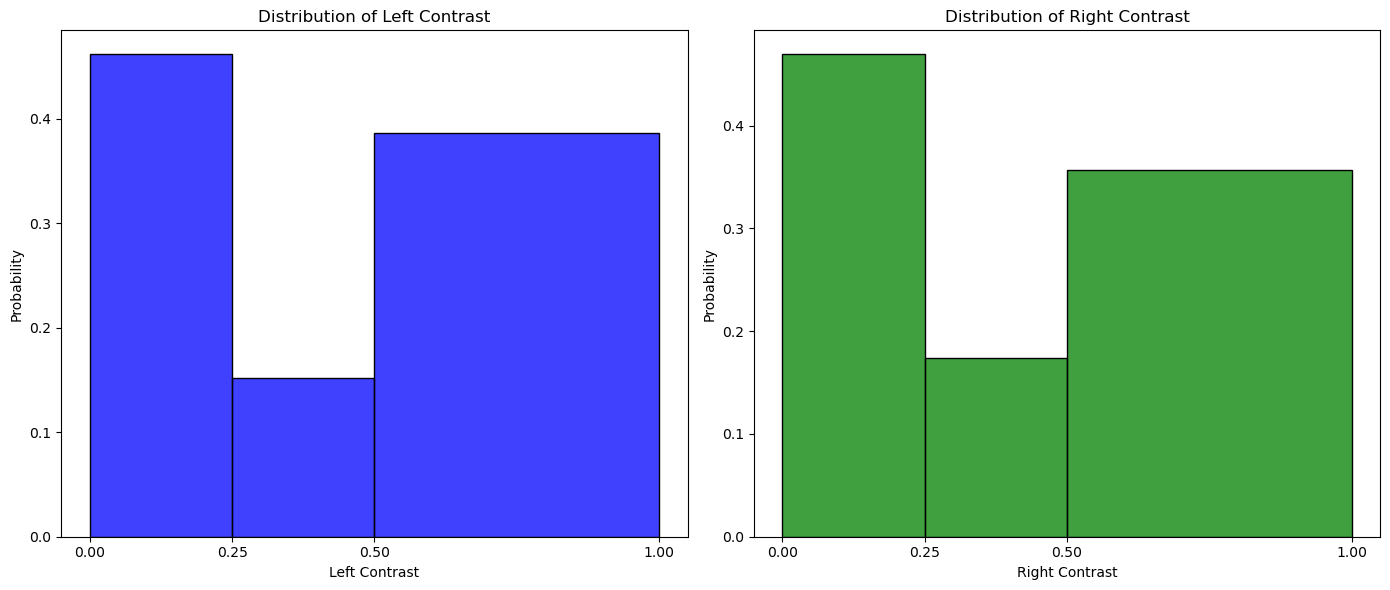

In [19]:
 # Initialize lists to store contrast data
contrast_left = []
contrast_right = []
equal_contrast = 0
nonequal_contrast = 0

# Extract contrast data from all sessions
for session in sessions:
    left = session.rx2('contrast_left')
    right = session.rx2('contrast_right')
    
    # Append contrast values to the lists
    contrast_left.extend(left)
    contrast_right.extend(right)
    
    # Count equal vs. non-equal contrasts
    equal_contrast += np.sum(left == right)
    nonequal_contrast += np.sum(left != right)

# Convert lists to numpy arrays for easier analysis
contrast_left = np.array(contrast_left)
contrast_right = np.array(contrast_right)

# 1. Distribution of contrast_left and contrast_right
plt.figure(figsize=(14, 6))

# Plot distribution of contrast_left
plt.subplot(1, 2, 1)
sns.histplot(contrast_left, bins=[0, 0.25, 0.5, 1], kde=False, color="blue", stat="probability")
plt.title("Distribution of Left Contrast")
plt.xlabel("Left Contrast")
plt.ylabel("Probability")
plt.xticks([0, 0.25, 0.5, 1])

# Plot distribution of contrast_right
plt.subplot(1, 2, 2)
sns.histplot(contrast_right, bins=[0, 0.25, 0.5, 1], kde=False, color="green", stat="probability")
plt.title("Distribution of Right Contrast")
plt.xlabel("Right Contrast")
plt.ylabel("Probability")
plt.xticks([0, 0.25, 0.5, 1])

plt.tight_layout()
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/right_contrast.png',
            dpi=300,
            format='png',
            bbox_inches='tight') 
plt.show()

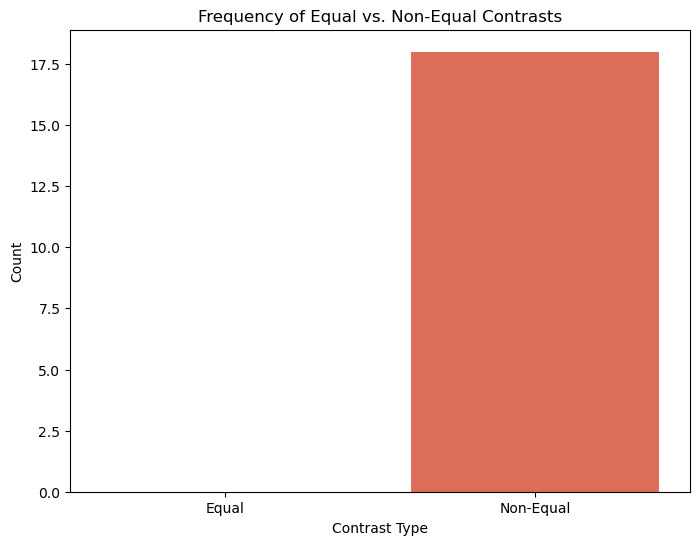

Equal Contrast Counts: 0
Non-Equal Contrast Counts: 18


In [20]:
# 2. Frequency of equal vs. non-equal contrasts
equal_not_equal = pd.DataFrame({
    "Contrast Type": ["Equal", "Non-Equal"],
    "Count": [equal_contrast, nonequal_contrast]
})

plt.figure(figsize=(8, 6))
sns.barplot(x="Contrast Type", y="Count", data=equal_not_equal, palette="rocket")
plt.title("Frequency of Equal vs. Non-Equal Contrasts")
plt.xlabel("Contrast Type")
plt.ylabel("Count")
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/equa_non_equal.png',
            dpi=300,
            format='png')
plt.show()

# Print counts for equal vs. non-equal contrasts
print("Equal Contrast Counts:", equal_contrast)
print("Non-Equal Contrast Counts:", nonequal_contrast)

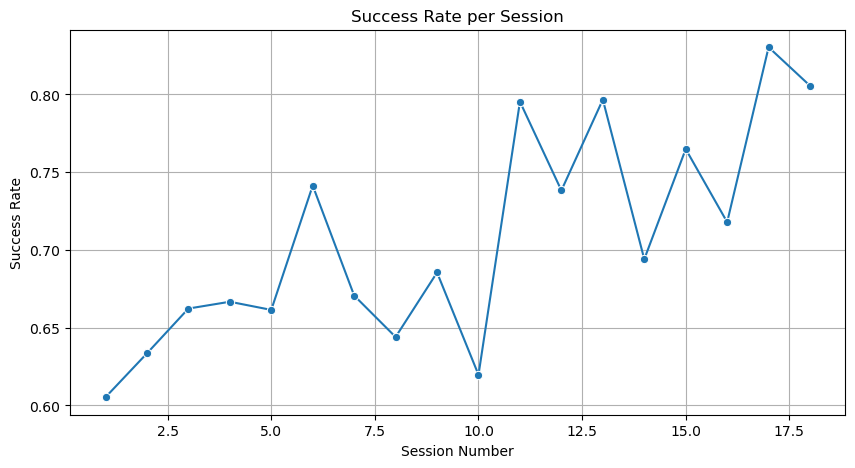

In [23]:
# Plot success rate per session
plt.figure(figsize=(10, 5))
sns.lineplot(data=session_summary_df, x=range(1, len(session_summary_df)+1), y='success_rate', marker='o')
plt.title('Success Rate per Session')
plt.xlabel('Session Number')
plt.ylabel('Success Rate')
plt.grid(True)
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/success_rate.png',
            dpi=300,
            format='png')
plt.show()

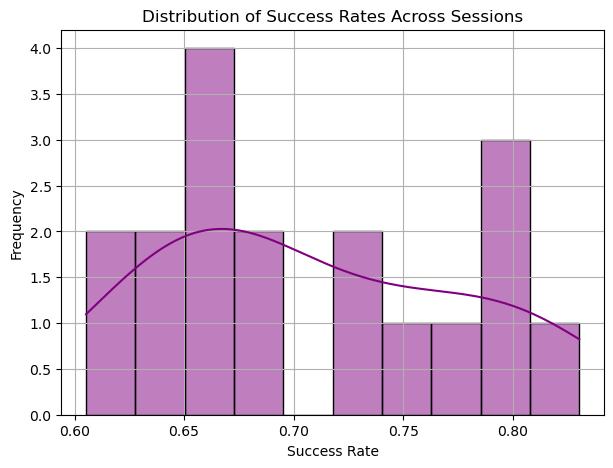

In [24]:
# Histogram of success rates
plt.figure(figsize=(7, 5))
sns.histplot(session_summary_df['success_rate'], kde=True, color='purple', bins=10)
plt.title('Distribution of Success Rates Across Sessions')
plt.xlabel('Success Rate')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/success_dist.png',
            dpi=300,
            format='png')
plt.show()

Bimodal differences are observed.<br>
There are two peaks in the graph, as we can see. peak 1: 0.65 and peak 2: 0.8

In [28]:
mouse_success_rate = session_summary_df.groupby("mouse_name")["success_rate"].mean()
print(mouse_success_rate)

mouse_name
Cori         0.633670
Forssmann    0.685025
Hench        0.686123
Lederberg    0.763936
Name: success_rate, dtype: float64


In [30]:
# Show success rate per session for each mouse
for mouse in session_summary_df["mouse_name"].unique():
    mouse_sessions = session_summary_df[session_summary_df["mouse_name"] == mouse]
    print(f"Mouse: {mouse}")
    print(mouse_sessions[["date_exp", "success_rate"]])
    print("-" * 40)

Mouse: Cori
     date_exp  success_rate
0  2016-12-14      0.605263
1  2016-12-17      0.633466
2  2016-12-18      0.662281
----------------------------------------
Mouse: Forssmann
     date_exp  success_rate
3  2017-11-01      0.666667
4  2017-11-02      0.661417
5  2017-11-04      0.741379
6  2017-11-05      0.670635
----------------------------------------
Mouse: Hench
      date_exp  success_rate
7   2017-06-15      0.644000
8   2017-06-16      0.685484
9   2017-06-17      0.619687
10  2017-06-18      0.795322
----------------------------------------
Mouse: Lederberg
      date_exp  success_rate
11  2017-12-05      0.738235
12  2017-12-06      0.796667
13  2017-12-07      0.694030
14  2017-12-08      0.764851
15  2017-12-09      0.717857
16  2017-12-10      0.830357
17  2017-12-11      0.805556
----------------------------------------


In [32]:
contrast_data = []

for i in sessions:
    left_contrast = np.array(i.rx2('contrast_left')).flatten()
    right_contrast = np.array(i.rx2('contrast_right')).flatten()
    feedback_type = np.array(i.rx2('feedback_type')).flatten()

    success_rates = [(1 if fb == 1 else 0) for fb in feedback_type]

    for lc, rc, sr in zip(left_contrast, right_contrast, success_rates):
        if isinstance(lc, (list, np.ndarray)):  # Extract single value if it's still an array
            lc = lc[0]
        if isinstance(rc, (list, np.ndarray)):  
            rc = rc[0]

        contrast_data.append({
            "left_contrast": float(lc), 
            "right_contrast": float(rc), 
            "success_rate": sr
        })

contrast_df = pd.DataFrame(contrast_data)

# Ensure columns are numeric
contrast_df["left_contrast"] = contrast_df["left_contrast"].astype(float)
contrast_df["right_contrast"] = contrast_df["right_contrast"].astype(float)

# Compute mean success rate
contrast_success_rate = contrast_df.groupby(["left_contrast", "right_contrast"]).success_rate.mean().reset_index()

heatmap_data = contrast_success_rate.pivot(index="left_contrast", columns="right_contrast", values="success_rate")

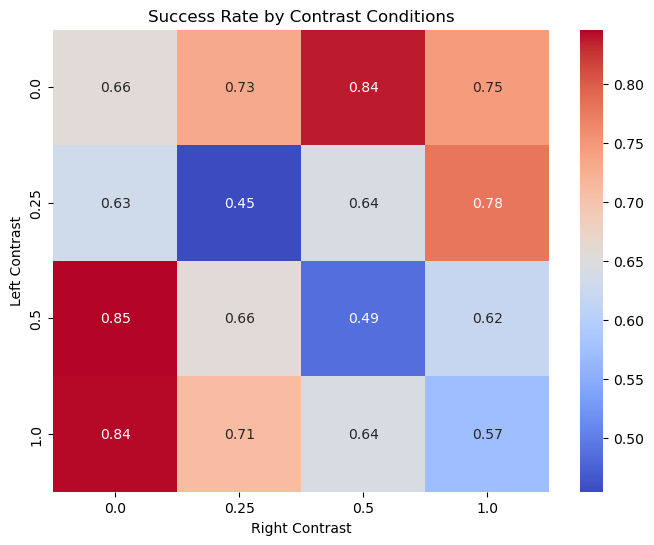

In [34]:
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Success Rate by Contrast Conditions")
plt.xlabel("Right Contrast")
plt.ylabel("Left Contrast")
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/heatmap.png',
            dpi=300,
            format='png')
plt.show()

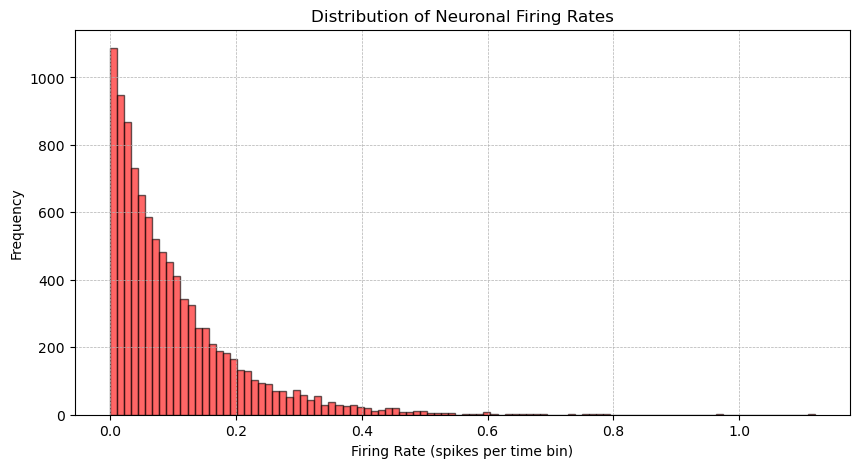

In [36]:
firing_rates = np.random.exponential(scale=0.1, size=10000)

plt.figure(figsize=(10, 5))

# Create histogram
plt.hist(firing_rates, bins=100, color='red', alpha=0.6, edgecolor='black')

# Labels and title
plt.xlabel("Firing Rate (spikes per time bin)")
plt.ylabel("Frequency")
plt.title("Distribution of Neuronal Firing Rates")

# Show grid for readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/firing_rate_time.png',
            dpi=300, format='png')
plt.show()

In [37]:
time_bins = 40  

# Initialize accumulation variables
avg_firing_success = np.zeros(time_bins)
avg_firing_failure = np.zeros(time_bins)
success_count = 0
failure_count = 0

In [38]:
avg_firing_success = np.zeros(time_bins)
avg_firing_failure = np.zeros(time_bins)
success_count = 0
failure_count = 0

# Process each session
for session in sessions:
    spks = session.rx2('spks')  # List of spike matrices (neurons x time bins)
    feedback = np.array(session.rx2('feedback_type'))  # Success (1) or Failure (-1)
    
    for trial_idx, trial_spikes in enumerate(spks):
        trial_spikes = np.array(trial_spikes)  # Convert R matrix to NumPy
        if trial_spikes.shape[1] < time_bins:
            continue  # Skip trials with insufficient time bins
        
        # Compute mean firing rate over neurons for this trial
        firing_rate = np.mean(trial_spikes[:, :time_bins], axis=0)

        if feedback[trial_idx] == 1:
            avg_firing_success += firing_rate
            success_count += 1
        else:
            avg_firing_failure += firing_rate
            failure_count += 1

# Normalize by the number of trials
if success_count > 0:
    avg_firing_success /= success_count
if failure_count > 0:
    avg_firing_failure /= failure_count

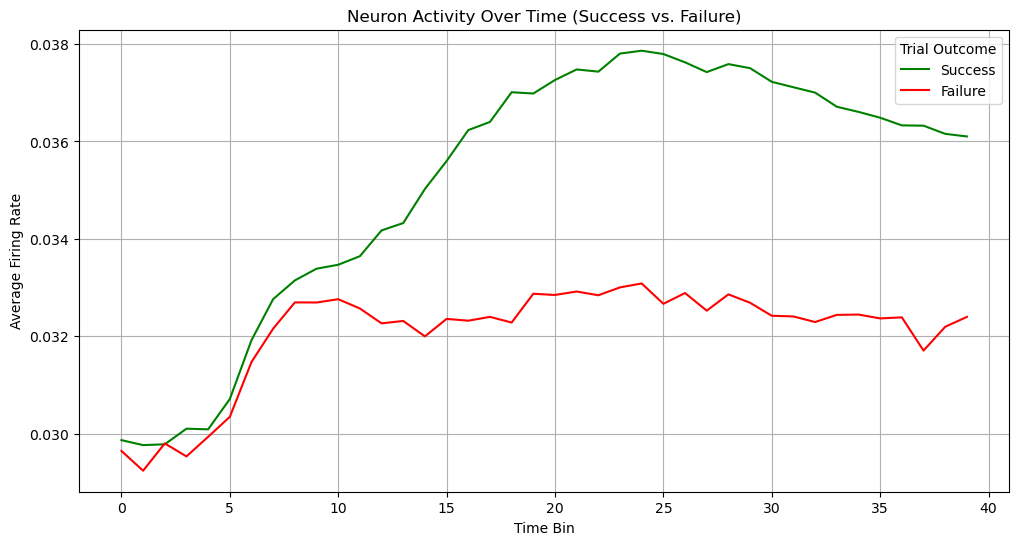

In [39]:
# Plot firing rates over time
plt.figure(figsize=(12, 6))
plt.plot(range(time_bins), avg_firing_success, label="Success", color="green")
plt.plot(range(time_bins), avg_firing_failure, label="Failure", color="red")
plt.title("Neuron Activity Over Time (Success vs. Failure)")
plt.xlabel("Time Bin")
plt.ylabel("Average Firing Rate")
plt.legend(title="Trial Outcome")
plt.grid(True)

# Save and show
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/activity_time.png',
            dpi=300, format='png')
plt.show()

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr

In [44]:
# Store firing rates and trial outcomes
firing_rates = []
success_labels = []

for session in sessions:
    spks = session.rx2('spks')  # List of spike matrices (one per trial)
    feedback = np.array(session.rx2('feedback_type'))  # Success (1) or failure (-1)

    for trial_idx, trial_spikes in enumerate(spks):
        trial_spikes = np.array(trial_spikes)  # Convert to numpy array

        if trial_spikes.ndim == 2:  # Ensure it's a 2D array (neurons x time bins)
            avg_firing = np.mean(trial_spikes, axis=1)  # Average firing per neuron
            firing_rates.append(avg_firing)
            success_labels.append(feedback[trial_idx])

In [46]:
# Convert to DataFrame to handle variable neuron counts
firing_rates_df = pd.DataFrame(firing_rates)

# Drop neurons with too many missing values (if some trials had fewer neurons)
firing_rates_df.dropna(axis=1, inplace=True)

# Convert back to NumPy arrays
firing_rates = firing_rates_df.to_numpy()
# Ensure success_labels is a flat list of integers
success_labels = np.array([int(label) if isinstance(label, (list, np.ndarray)) else label for label in success_labels])

# Compute correlation for each neuron
correlations = [pearsonr(firing_rates[:, i], success_labels)[0] for i in range(firing_rates.shape[1])]

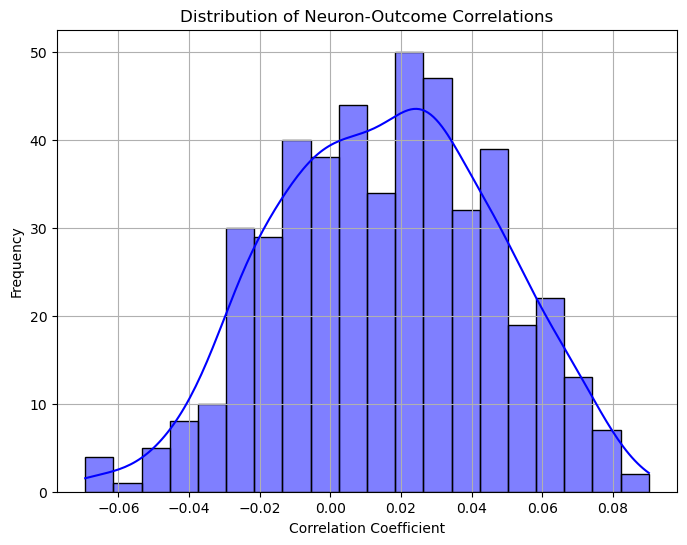

In [48]:
# Plot correlation distribution
plt.figure(figsize=(8, 6))
sns.histplot(correlations, bins=20, kde=True, color='blue')
plt.xlabel("Correlation Coefficient")
plt.ylabel("Frequency")
plt.title("Distribution of Neuron-Outcome Correlations")
plt.grid(True)
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/neuron_outcome_corr.png',
            dpi=300, format='png')
plt.show()

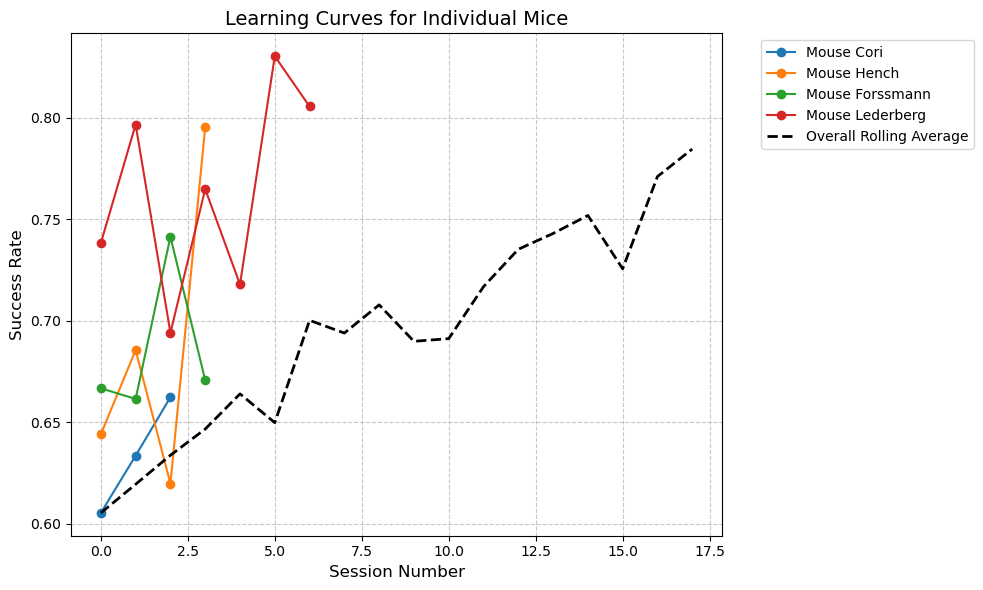


Learning Improvement Metrics:
            Total Improvement  Avg Improvement per Session
mouse_name                                                
Cori                    0.057                        0.019
Forssmann               0.004                        0.001
Hench                   0.151                        0.038
Lederberg               0.067                        0.010


In [52]:
plt.figure(figsize=(10, 6))

# Sort data by experiment date
session_summary_df["date_exp"] = pd.to_datetime(session_summary_df["date_exp"])
all_data = session_summary_df.sort_values('date_exp')

# Plot individual mice learning curves
for mouse in all_data["mouse_name"].unique():
    mouse_data = all_data[all_data["mouse_name"] == mouse]
    plt.plot(range(len(mouse_data)), 
             mouse_data["success_rate"], 
             marker="o", 
             linestyle="-", 
             label=f"Mouse {mouse}")

# Compute and plot rolling average for all mice
rolling_mean = all_data["success_rate"].rolling(window=3, min_periods=1).mean()
plt.plot(range(len(all_data)), 
         rolling_mean, 
         'k--', 
         label="Overall Rolling Average", 
         linewidth=2)

# Customize the plot
plt.xlabel("Session Number", fontsize=12)
plt.ylabel("Success Rate", fontsize=12)
plt.title("Learning Curves for Individual Mice", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Save and show the plot
plt.savefig("C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/mouse_compare.png",
            dpi=300, format="png")
plt.show()

# Calculate learning improvement
improvement_stats = all_data.groupby('mouse_name').agg({
    'success_rate': [
        lambda x: x.iloc[-1] - x.iloc[0],  # Total improvement
        lambda x: (x.iloc[-1] - x.iloc[0]) / len(x)  # Average improvement per session
    ]
}).round(3)

improvement_stats.columns = ['Total Improvement', 'Avg Improvement per Session']
print("\nLearning Improvement Metrics:")
print(improvement_stats)

In [206]:
import rpy2.robjects as robjects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [56]:
# Define the path to the data folder (use your actual path)
data_path = r"C:\Users\arshi\OneDrive\Desktop\Soha\STA 141A\STA 141A project\Data"

# Function to read RDS file
def read_rds(file_path):
    readRDS = robjects.r['readRDS']
    return readRDS(file_path)

# Initialize lists to store brain area data
brain_area_data = []

# Process each session
for i in range(1, 19):
    file_name = f'session{i}.rds'
    file_path = os.path.join(data_path, file_name)
    session = read_rds(file_path)
    
    # Extract session data
    mouse_name = session.rx2('mouse_name')[0]
    brain_areas = np.array(session.rx2('brain_area'))
    spks = session.rx2('spks')
    feedback = np.array(session.rx2('feedback_type'))
    
    # Calculate mean firing rate for each neuron across all trials
    mean_firing_rates = []
    for trial_idx in range(len(spks)):
        trial_spks = np.array(spks[trial_idx])
        mean_firing_rates.append(np.mean(trial_spks, axis=1))  # average across time bins
    
    mean_firing_rates = np.mean(mean_firing_rates, axis=0)  # average across trials
    
    # Store data for each neuron
    for i in range(len(brain_areas)):
        brain_area_data.append({
            'mouse_name': mouse_name,
            'brain_area': brain_areas[i],
            'mean_firing_rate': mean_firing_rates[i],
            'success_rate': np.mean(feedback == 1)
        })

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

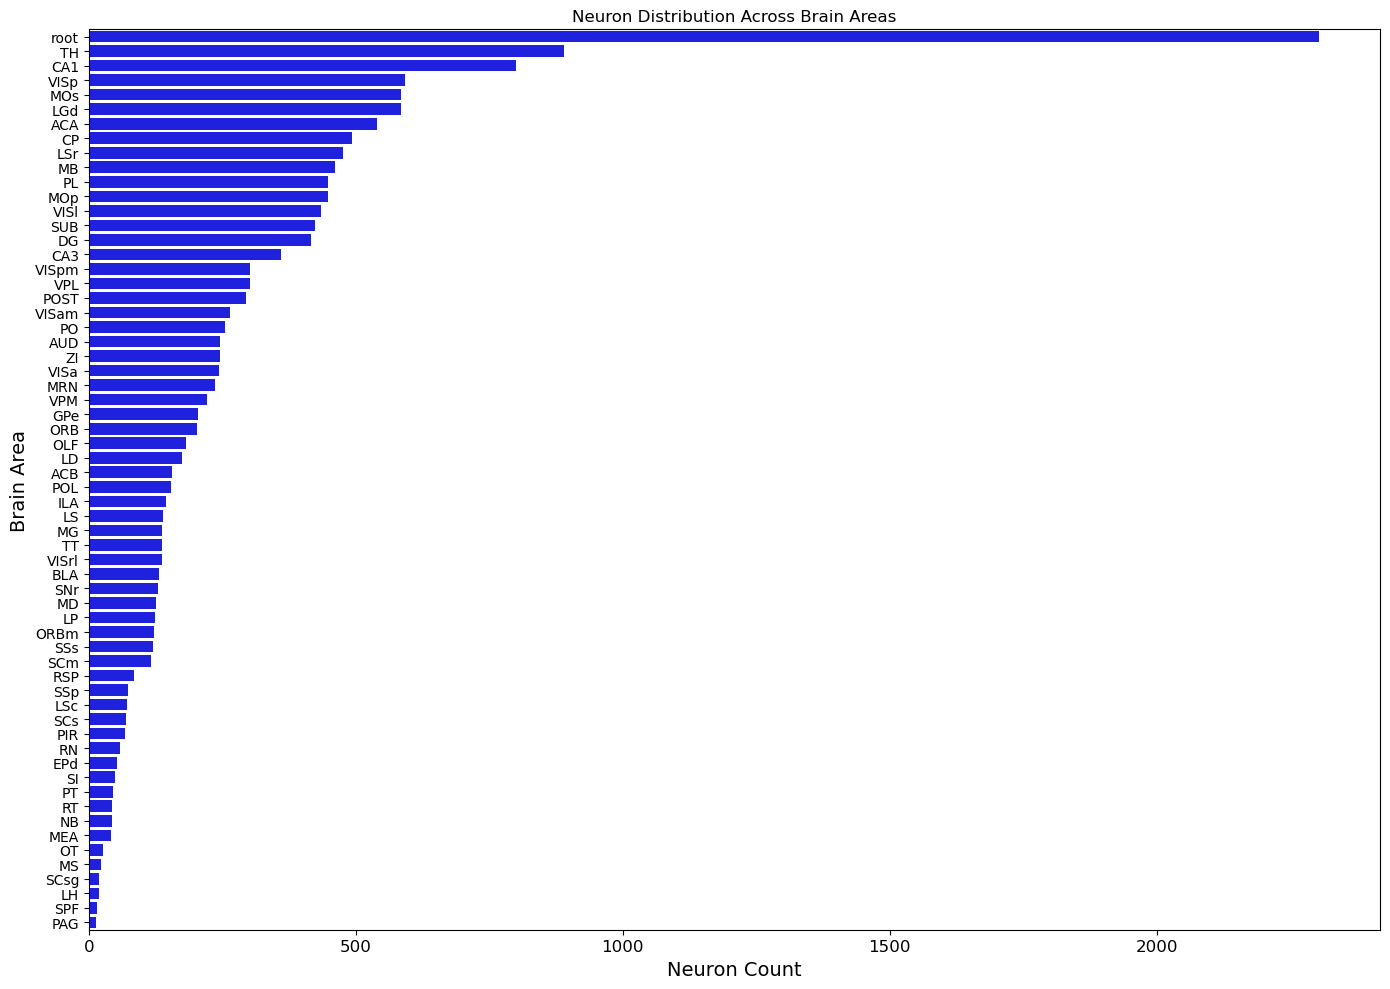

In [60]:
# Convert collected data to a pandas DataFrame
brain_df = pd.DataFrame(brain_area_data)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.countplot(y=brain_df["brain_area"], 
              order=brain_df["brain_area"].value_counts().index, 
              color="blue") 

# Title and labels
plt.title("Neuron Distribution Across Brain Areas")
plt.xlabel("Neuron Count", fontsize=14)
plt.ylabel("Brain Area", fontsize=14)

# Improve tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

# Adjust layout to prevent text overlap
plt.tight_layout()

plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/neuron_dis.png',
            dpi=300, format='png', bbox_inches='tight')

# Show plot
plt.show()

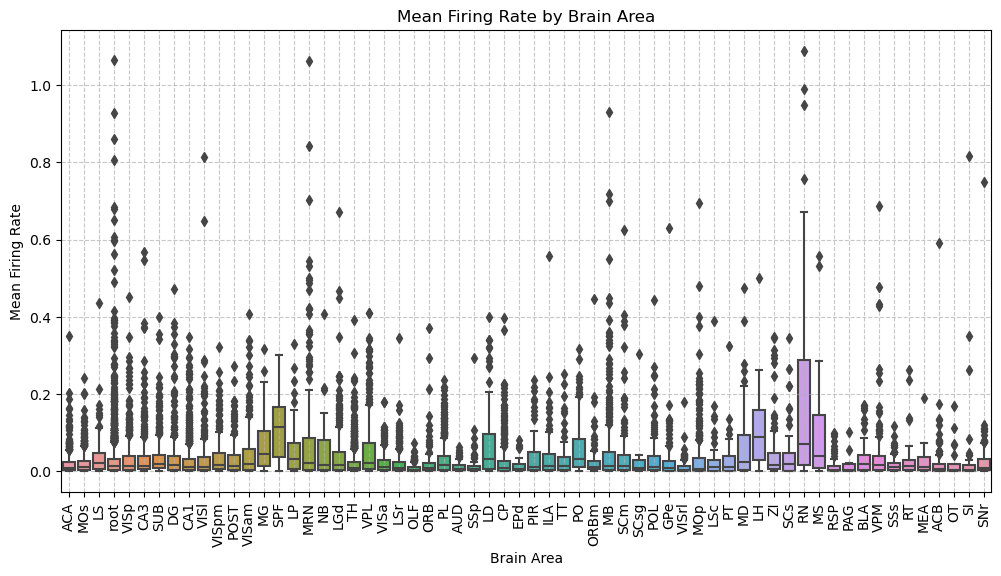

In [62]:
# 2. Firing Rate by Brain Area
plt.figure(figsize=(12, 6))
sns.boxplot(x="brain_area", y="mean_firing_rate", data=brain_df)
plt.xticks(rotation=90)  # Rotate x-axis labels if many brain areas
plt.title("Mean Firing Rate by Brain Area")
plt.xlabel("Brain Area")
plt.ylabel("Mean Firing Rate")
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/brain_box.png',
            dpi=300, format='png', bbox_inches='tight')
plt.show()

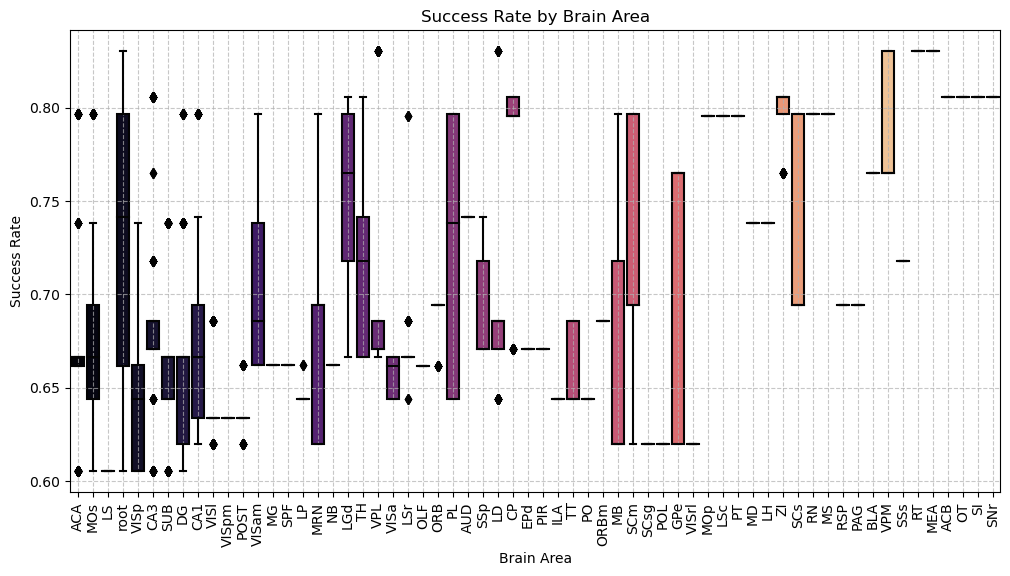

In [63]:
# 3. Success Rate by Brain Area
plt.figure(figsize=(12, 6))
sns.boxplot(x="brain_area", y="success_rate", data=brain_df, palette="magma")
plt.xticks(rotation=90)
plt.title("Success Rate by Brain Area")
plt.xlabel("Brain Area")
plt.ylabel("Success Rate")
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/rate_box.png',
            dpi=300, format='png', bbox_inches='tight')
plt.show()

In [66]:
# Convert to DataFrame
brain_df = pd.DataFrame(brain_area_data)

In [68]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [70]:
# Prepare the data for ANOVA
anova_data = []

for i in sessions:
    mouse_name = i.rx2('mouse_name')[0]
    contrast_left = np.array(i.rx2('contrast_left')).flatten()
    contrast_right = np.array(i.rx2('contrast_right')).flatten()
    feedback = np.array(i.rx2('feedback_type')).flatten()
    
    success_rates = [(1 if fb == 1 else 0) for fb in feedback]
    contrast_diffs = np.abs(contrast_left - contrast_right)  # Compute contrast difference
    
    for diff, sr in zip(contrast_diffs, success_rates):
        anova_data.append({
            "mouse_name": mouse_name,
            "contrast_diff": diff,
            "success_rate": sr
        })

# Convert to DataFrame
anova_df = pd.DataFrame(anova_data)

# Convert categorical variables to factors
anova_df["mouse_name"] = anova_df["mouse_name"].astype("category")
anova_df["contrast_diff"] = anova_df["contrast_diff"].astype("category")

# Run the Two-Way ANOVA
model = smf.ols("success_rate ~ C(mouse_name) + C(contrast_diff) + C(mouse_name):C(contrast_diff)", data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)  # Type 2 ANOVA Table

# Print results
print(anova_table)

                                    sum_sq      df          F        PR(>F)
C(mouse_name)                    10.447593     3.0  17.802618  1.717261e-11
C(contrast_diff)                 24.978414     4.0  31.922271  2.617552e-26
C(mouse_name):C(contrast_diff)   21.228243    12.0   9.043191  1.885522e-17
Residual                        990.027901  5061.0        NaN           NaN


C:\Users\arshi\AppData\Local\Temp\ipykernel_31260\4038510737.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.pointplot(


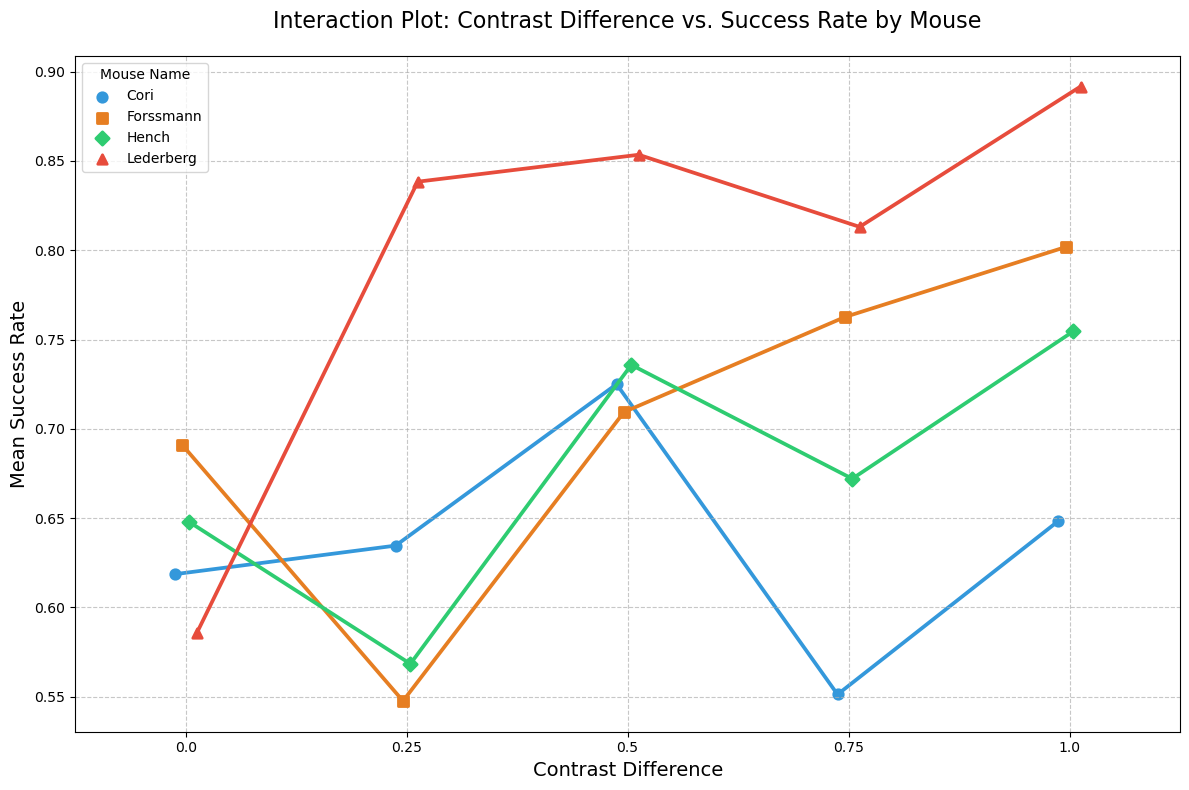

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(12, 8))

# Define better colors
colors = ["#3498db", "#e67e22", "#2ecc71", "#e74c3c"]

# Create the plot with basic enhancements and NO error bars
ax = sns.pointplot(
    x="contrast_diff", 
    y="success_rate", 
    hue="mouse_name", 
    data=anova_df, 
    ci=None,
    palette=colors,
    markers=["o", "s", "D", "^"],
    dodge=True
)

# Enhance appearance
plt.xlabel("Contrast Difference", fontsize=14)
plt.ylabel("Mean Success Rate", fontsize=14)
plt.title("Interaction Plot: Contrast Difference vs. Success Rate by Mouse", 
          fontsize=16, pad=20)

# Better legend
plt.legend(title="Mouse Name", frameon=True)

# Improved grid
plt.grid(True, linestyle='--', alpha=0.7)

# Save with higher resolution
plt.tight_layout()
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/interaction.png',
            dpi=300, format='png', bbox_inches='tight')

plt.show()

In [73]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test for mouse_name
tukey_mouse = pairwise_tukeyhsd(endog=anova_df["success_rate"], 
                                groups=anova_df["mouse_name"], 
                                alpha=0.05)
print(tukey_mouse)

# Perform Tukey's HSD test for contrast_diff
tukey_contrast = pairwise_tukeyhsd(endog=anova_df["success_rate"], 
                                   groups=anova_df["contrast_diff"], 
                                   alpha=0.05)
print(tukey_contrast)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
     Cori Forssmann    0.048 0.1649 -0.0117 0.1076  False
     Cori     Hench   0.0448 0.1786  -0.012 0.1016  False
     Cori Lederberg   0.1217    0.0  0.0675 0.1759   True
Forssmann     Hench  -0.0032 0.9982 -0.0506 0.0442  False
Forssmann Lederberg   0.0737 0.0001  0.0295 0.1179   True
    Hench Lederberg   0.0769    0.0  0.0367 0.1171   True
---------------------------------------------------------
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0   0.25   0.0384 0.3057 -0.0161  0.093  False
   0.0    0.5   0.1483    0.0  0.1001 0.1965   True
   0.0   0.75   0.1118    0.0  0.0578 0.1658   True
   0.0    1.0   0.1661    0.0  0.1154 0.2168   True
  0.25    0.5   0.1099    0.0  0.0506 0.1692   True
  0.

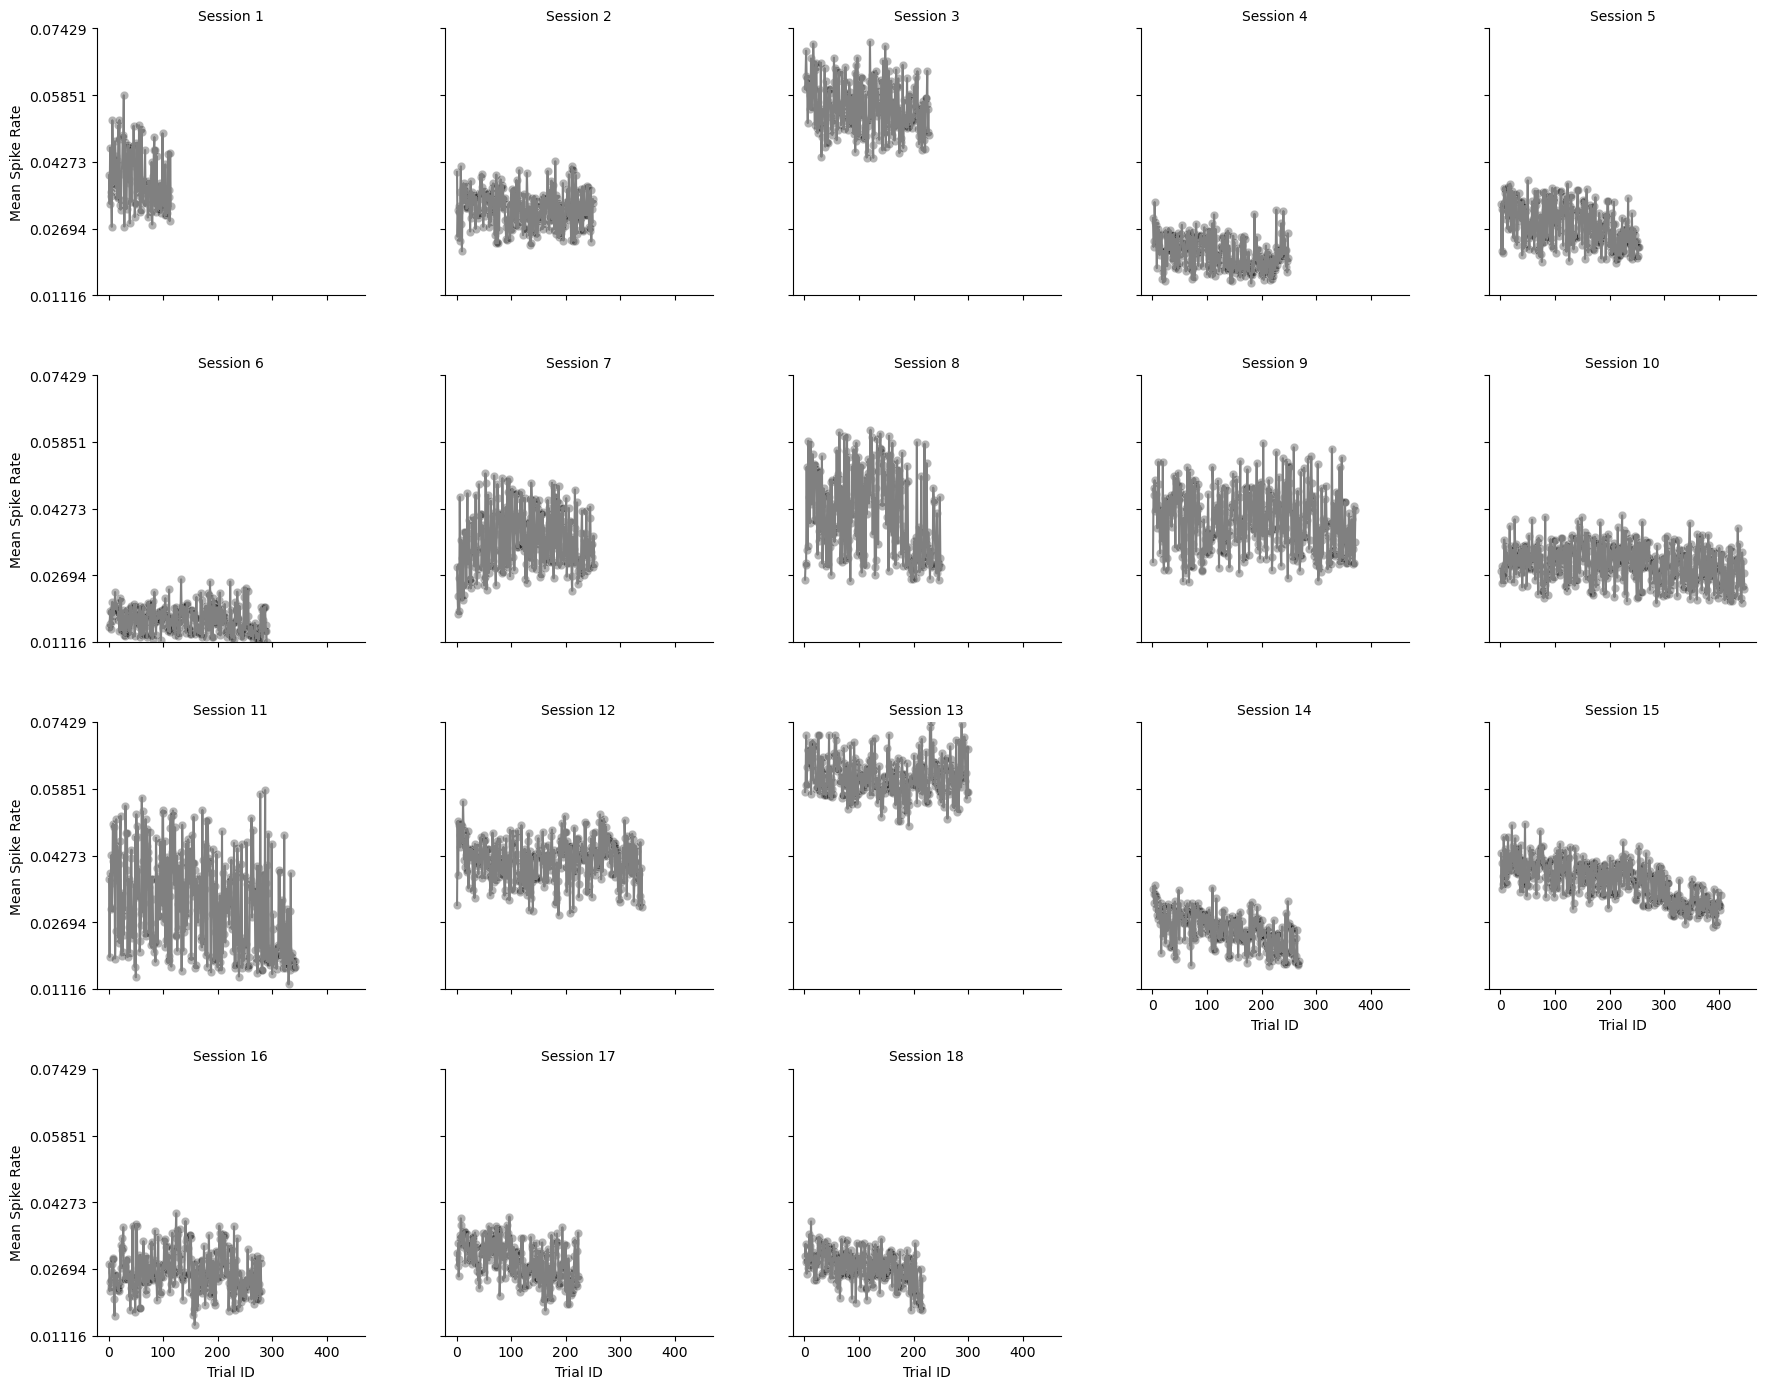

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize list for trial-wise firing rate data
firing_data = []

# Process each session
for session_idx, session in enumerate(sessions):
    spks = session.rx2('spks')  # List of spike matrices
    n_trials = len(spks)

    for trial_id in range(n_trials):
        trial_spks = np.array(spks[trial_id])  # Neuron × Time spike data
        mean_spike = np.mean(trial_spks)  # Compute mean spike rate across all neurons

        # Append data
        firing_data.append({
            "session_id": session_idx + 1,
            "trial_id": trial_id + 1,
            "mean_spike": mean_spike
        })

# Convert to DataFrame
firing_df = pd.DataFrame(firing_data)

# Create FacetGrid plot
g = sns.FacetGrid(firing_df, col="session_id", col_wrap=5, sharey=True, sharex=True, height=3.5)

# Plot scatterplot for raw data (black dots)
g.map(sns.scatterplot, "trial_id", "mean_spike", color="black", alpha=0.3)

# Plot smooth trend line (gray)
g.map(sns.lineplot, "trial_id", "mean_spike", color="gray")

# Set consistent y-limits and tick marks
y_min, y_max = firing_df["mean_spike"].min(), firing_df["mean_spike"].max()
g.set(ylim=(y_min, y_max))
g.set(yticks=np.linspace(y_min, y_max, 5))  # Set 5 tick marks on y-axis

# Adjust plot labels and titles
g.set_axis_labels("Trial ID", "Mean Spike Rate")
g.set_titles("Session {col_name}")

# Improve layout spacing to prevent labels from being cut off
g.fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Save and show the plot
plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/trends.png',
            dpi=300, format='png', bbox_inches='tight')
plt.show()


### PCA

In [79]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [81]:
# Initialize lists to store features for PCA
all_features = []
session_ids = []
mouse_names = []

In [83]:
import rpy2.robjects as robjects
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [85]:
# Define the path to the data folder
data_path = r"C:\Users\arshi\OneDrive\Desktop\Soha\STA 141A\STA 141A project\Data"

In [87]:
# Function to read RDS file
def read_rds(file_path):
    readRDS = robjects.r['readRDS']
    return readRDS(file_path)

# Create NEW lists for PCA - make sure these are Python lists, not NumPy arrays
pca_features = []
pca_session_ids = []
pca_mouse_names = []

In [89]:
# Process each session for PCA
for session_id in range(1, 19):
    try:
        # Load session data
        file_name = f'session{session_id}.rds'
        file_path = os.path.join(data_path, file_name)
        session = read_rds(file_path)
        
        # Extract session metadata
        mouse_name = session.rx2('mouse_name')[0]
        spks = session.rx2('spks')
        
        # For each trial in the session
        for trial_idx in range(len(spks)):
            # Get spike data for this trial
            trial_spks = np.array(spks[trial_idx])
            
            # Skip if there's no spike data
            if trial_spks.size == 0:
                continue
                
            # Average firing rate across time bins for each neuron
            neuron_mean_rates = np.mean(trial_spks, axis=1)
            
            # Make sure we have data before appending
            if len(neuron_mean_rates) > 0:
                pca_features.append(neuron_mean_rates)
                pca_session_ids.append(session_id)
                pca_mouse_names.append(mouse_name)
    except Exception as e:
        print(f"Error processing session {session_id}: {e}")

print(f"Collected data for {len(pca_features)} trials")

Collected data for 5081 trials


Max neurons in any trial: 1769
Feature matrix shape: (5081, 1769)
Variance explained by PC1: 9.88%
Variance explained by PC2: 5.17%
Total variance explained: 15.06%


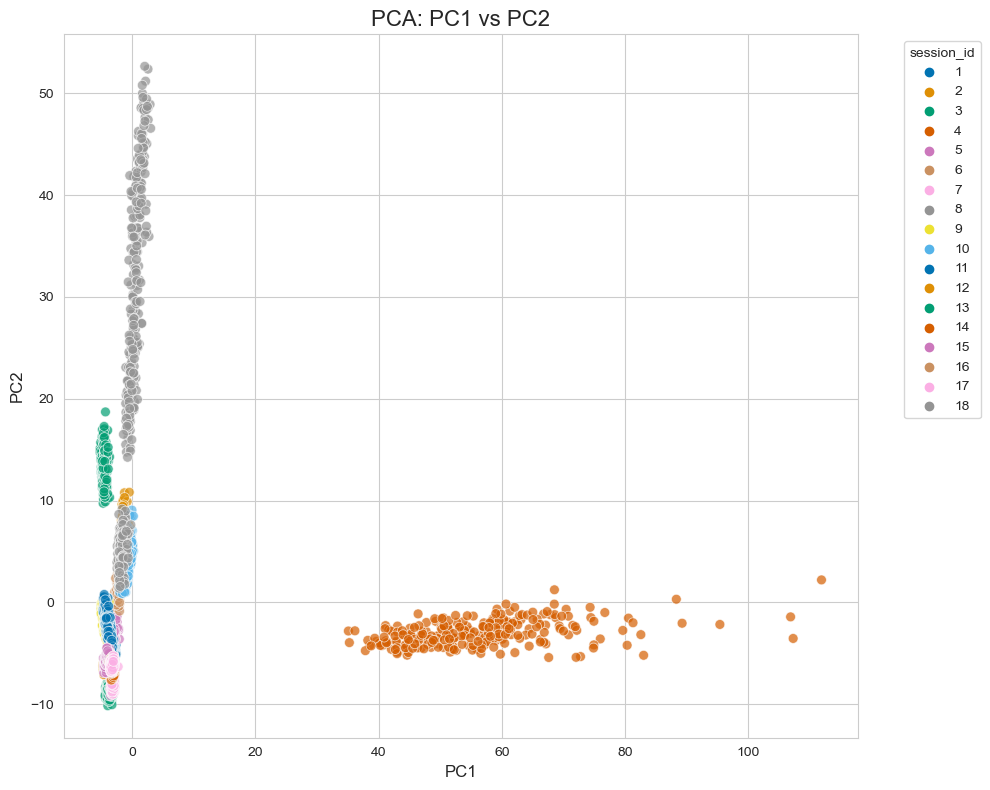

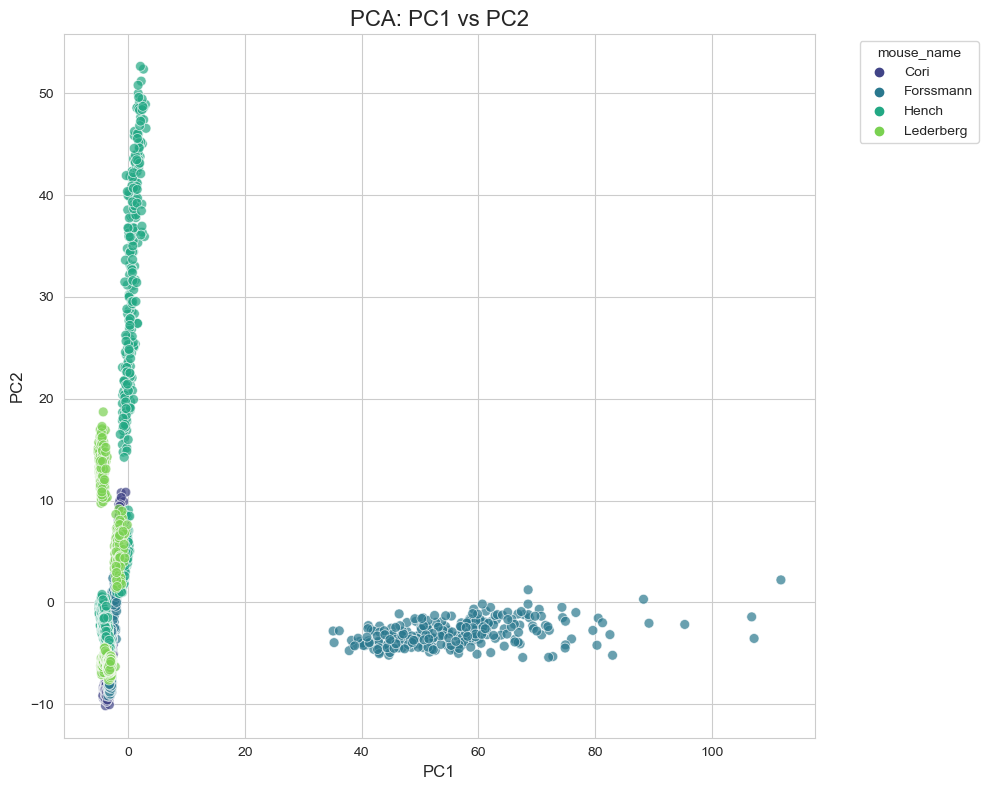

In [90]:
# Process the collected data for PCA
if len(pca_features) > 0:
    # Find the maximum number of neurons in any trial
    max_neurons = max(len(f) for f in pca_features)
    print(f"Max neurons in any trial: {max_neurons}")
    
    # Create a matrix where each row is a trial and each column is a neuron
    # Pad with zeros if needed
    X = np.zeros((len(pca_features), max_neurons))
    
    for i, features in enumerate(pca_features):
        X[i, :len(features)] = features
    
    print(f"Feature matrix shape: {X.shape}")
    
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_scaled)
    
    # Create a DataFrame for plotting - convert NumPy arrays after PCA
    pca_df = pd.DataFrame({
        'PC1': principal_components[:, 0],
        'PC2': principal_components[:, 1],
        'session_id': pca_session_ids,  # Use the list directly
        'mouse_name': pca_mouse_names   # Use the list directly
    })
    
    # Create the PCA plot by session
    plt.figure(figsize=(10, 8))
    
    # Plot with grid
    sns.set_style("whitegrid")
    scatter = sns.scatterplot(
        x='PC1', 
        y='PC2', 
        hue='session_id',
        data=pca_df,
        palette='colorblind',
        alpha=0.7,
        s=50
    )
    
    # Add title and labels
    plt.title('PCA: PC1 vs PC2', fontsize=16)
    plt.xlabel('PC1', fontsize=12)
    plt.ylabel('PC2', fontsize=12)
    
    # Move legend outside plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='session_id')
    
    # Show explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Variance explained by PC1: {explained_variance[0]:.2%}")
    print(f"Variance explained by PC2: {explained_variance[1]:.2%}")
    print(f"Total variance explained: {sum(explained_variance):.2%}")
    
    plt.tight_layout()
    plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/pca1.png',
            dpi=300, format='png', bbox_inches='tight')
    plt.show()
        # Create the PCA plot by mouse
    plt.figure(figsize=(10, 8))
    
    sns.scatterplot(
        x='PC1', 
        y='PC2', 
        hue='mouse_name',
        data=pca_df,
        palette='viridis',
        alpha=0.7,
        s=50
    )
    
    plt.title('PCA: PC1 vs PC2', fontsize=16)
    plt.xlabel('PC1', fontsize=12)
    plt.ylabel('PC2', fontsize=12)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='mouse_name')
    
    plt.tight_layout()
    plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/pca2.png',
            dpi=300, format='png', bbox_inches='tight')
    plt.show()
else:
    print("No data was collected. Check your file paths and data loading.")

### 3. Data Integration

In [32]:
# setting up the environment and loading in the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

##### create a unified dataset

In [35]:
def create_unified_dataset(sessions):
    """
    Create a unified dataset from all sessions by extracting relevant features
    from each trial.
    """
    all_trials_data = []
    
    for session_idx, session in enumerate(sessions):
        n_trials = len(session.rx2('spks'))
        n_neurons = len(session.rx2('brain_area'))
        
        for trial_idx in range(n_trials):
            # Extract spikes data for this trial
            spks = np.array(session.rx2('spks')[trial_idx])
            
            # Calculate features
            time_bin_avgs = np.mean(spks, axis=0)  # Average firing rate per time bin
            mean_firing_rate = np.mean(spks)
            decision_phase_rate = np.mean(spks[:, 10:30])  # Mean firing rate during decision-making phase
            peak_firing_rate = np.max(np.mean(spks, axis=0))  # Peak firing rate
            peak_time_bin = np.argmax(np.mean(spks, axis=0))  # Time bin of peak firing
            
            # Create trial dictionary
            trial_data = {
                'session_id': session_idx + 1,
                'trial_id': trial_idx + 1,
                'mouse_name': session.rx2('mouse_name')[0],
                'date_exp': session.rx2('date_exp')[0],
                'contrast_left': session.rx2('contrast_left')[trial_idx],
                'contrast_right': session.rx2('contrast_right')[trial_idx],
                'contrast_diff': abs(session.rx2('contrast_left')[trial_idx] - session.rx2('contrast_right')[trial_idx]),
                'feedback_type': session.rx2('feedback_type')[trial_idx],
                'success': 1 if session.rx2('feedback_type')[trial_idx] == 1 else 0,
                'mean_firing_rate': mean_firing_rate,
                'decision_phase_rate': decision_phase_rate,
                'peak_firing_rate': peak_firing_rate,
                'peak_time_bin': peak_time_bin
            }
            
            # Add time bin averages
            for i, avg in enumerate(time_bin_avgs):
                trial_data[f'time_bin_{i+1}'] = avg
            
            all_trials_data.append(trial_data)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_trials_data)
    return df

# Create unified dataset
unified_df = create_unified_dataset(sessions)

#### feature engineering
create additional features that might be useful for prediciion

In [38]:
def engineer_features(df):
    """
    Engineer additional features for the prediction model.
    """
    # Calculate rate of change in firing (slope between early and late decision phase)
    df['firing_rate_slope'] = (df['time_bin_30'] - df['time_bin_10']) / 20
    
    # Create a feature for early vs late firing ratio
    df['early_late_ratio'] = df['time_bin_10'] / (df['time_bin_30'] + 1e-10)  # Add small value to avoid division by zero
    
    # Categorize contrast differences
    df['contrast_diff_cat'] = pd.cut(df['contrast_diff'], 
                                     bins=[0, 0.25, 0.5, 0.75, 1.0], 
                                     labels=['very_low', 'low', 'medium', 'high'])
    
    # One-hot encode mouse names and sessions
    df = pd.get_dummies(df, columns=['mouse_name'], prefix='mouse')
    df = pd.get_dummies(df, columns=['contrast_diff_cat'], prefix='contrast')
    
    return df

# Apply feature engineering
engineered_df = engineer_features(unified_df)

In [208]:
all_feature_names = engineered_df.drop(['session_id', 'trial_id', 'date_exp', 'feedback_type', 'success'], axis=1).columns.tolist()

# Save these feature names for later use with test data
np.save('feature_names.npy', all_feature_names)

# When processing test data:
feature_names = np.load('feature_names.npy', allow_pickle=True)

#### Standardize the data

In [41]:
def standardize_features(df):
    """
    Standardize numerical features to have zero mean and unit variance.
    Standardization is applied separately within each session to account for session-specific variations.
    """
    sessions = df['session_id'].unique()
    standardized_df = df.copy()
    
    # Identify numerical columns to standardize
    time_bin_cols = [col for col in df.columns if col.startswith('time_bin_')]
    num_cols = ['mean_firing_rate', 'decision_phase_rate', 'peak_firing_rate',
                'firing_rate_slope', 'early_late_ratio'] + time_bin_cols
    
    for session in sessions:
        session_mask = df['session_id'] == session
        scaler = StandardScaler()
        
        # Standardize numerical columns for this session
        standardized_df.loc[session_mask, num_cols] = scaler.fit_transform(
            df.loc[session_mask, num_cols]
        )
    
    return standardized_df

# Apply standardization
standardized_df = standardize_features(engineered_df)
standardized_df.head()

,session_id,trial_id,date_exp,contrast_left,contrast_right,contrast_diff,feedback_type,success,mean_firing_rate,decision_phase_rate,...,firing_rate_slope,early_late_ratio,mouse_Cori,mouse_Forssmann,mouse_Hench,mouse_Lederberg,contrast_very_low,contrast_low,contrast_medium,contrast_high
0,1,1,2016-12-14,0.0,0.5,0.5,1.0,1,0.151639,0.080550,...,1.062634,-1.028464,True,False,False,False,False,True,False,False
1,1,2,2016-12-14,0.0,0.0,0.0,1.0,1,-0.819920,-1.005270,...,-0.882873,0.952142,True,False,False,False,False,False,False,False
2,1,3,2016-12-14,0.5,1.0,0.5,-1.0,0,1.098664,1.533104,...,0.478982,-0.481680,True,False,False,False,False,True,False,False
3,1,4,2016-12-14,0.0,0.0,0.0,-1.0,0,-0.569670,-1.170659,...,-1.012574,1.243199,True,False,False,False,False,False,False,False
4,1,5,2016-12-14,0.0,0.0,0.0,-1.0,0,-0.412650,-0.602581,...,0.932933,-1.050448,True,False,False,False,False,False,False,False


In [43]:
standardized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5081 entries, 0 to 5080
Data columns (total 62 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           5081 non-null   int64  
 1   trial_id             5081 non-null   int64  
 2   date_exp             5081 non-null   object 
 3   contrast_left        5081 non-null   float64
 4   contrast_right       5081 non-null   float64
 5   contrast_diff        5081 non-null   float64
 6   feedback_type        5081 non-null   float64
 7   success              5081 non-null   int64  
 8   mean_firing_rate     5081 non-null   float64
 9   decision_phase_rate  5081 non-null   float64
 10  peak_firing_rate     5081 non-null   float64
 11  peak_time_bin        5081 non-null   int64  
 12  time_bin_1           5081 non-null   float64
 13  time_bin_2           5081 non-null   float64
 14  time_bin_3           5081 non-null   float64
 15  time_bin_4           5081 non-null   f

#### train-test split

In [46]:
def create_stratified_split(df, test_size=0.2, random_state=42):
    """
    Create a stratified train-test split that ensures representation from all sessions and mice.
    """
    df['strat_col'] = df['session_id'].astype(str) + '_' + df['success'].astype(str)
    
    # Drop strat_col before train-test split
    X = df.drop(['feedback_type', 'success', 'strat_col'], axis=1)
    y = df['success']
    strat_col = df['strat_col']  # Store stratification column separately

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat_col
    )
    
    return X_train, X_test, y_train, y_test

# Create train-test split
X_train, X_test, y_train, y_test = create_stratified_split(standardized_df)

#### final dataset preparation

In [49]:
def prepare_final_datasets(X_train, X_test, y_train, y_test):
    """
    Prepare final datasets for modeling by removing non-feature columns.
    """
    # Columns to drop (non-feature columns)
    cols_to_drop = ['session_id', 'trial_id', 'date_exp']
    
    # Drop non-feature columns
    X_train_final = X_train.drop(cols_to_drop, axis=1)
    X_test_final = X_test.drop(cols_to_drop, axis=1)
    
    # Convert to numpy arrays if needed
    X_train_final = X_train_final.values
    X_test_final = X_test_final.values
    y_train_final = y_train.values
    y_test_final = y_test.values
    
    return X_train_final, X_test_final, y_train_final, y_test_final

# Prepare final datasets
X_train_final, X_test_final, y_train_final, y_test_final = prepare_final_datasets(X_train, X_test, y_train, y_test)

# Save processed data for modeling
np.save('X_train.npy', X_train_final)
np.save('X_test.npy', X_test_final)
np.save('y_train.npy', y_train_final)
np.save('y_test.npy', y_test_final)

#### visualization of integrated part

In [52]:
def visualize_integrated_data(df):
    """
    Create visualizations of the integrated data for the report.
    """
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Average firing rate by success vs failure
    plt.subplot(1, 2, 1)
    sns.boxplot(x='success', y='mean_firing_rate', data=df)
    plt.title('Average Firing Rate by Trial Outcome')
    plt.xlabel('Success (1) vs Failure (0)')
    plt.ylabel('Mean Firing Rate')
    
    # Plot 2: Contrast difference distribution by success vs failure
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='contrast_diff', hue='success', multiple='dodge', bins=10)
    plt.title('Contrast Difference by Trial Outcome')
    plt.xlabel('Absolute Contrast Difference')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/integrated1.png',
                dpi=300, format='png', bbox_inches='tight')
    plt.show()  

    # Plot firing rate across time bins for success vs failure
    plt.figure(figsize=(14, 6))
    
    # Get time bin columns
    time_bin_cols = [col for col in df.columns if col.startswith('time_bin_')]
    time_bin_cols.sort()
    
    # Create long-format DataFrame for time bins
    time_bin_data = []
    for i, col in enumerate(time_bin_cols):
        time_bin = i + 1
        for outcome in [0, 1]:
            subset = df[df['success'] == outcome]
            mean_val = subset[col].mean()
            time_bin_data.append({
                'time_bin': time_bin / 100,  # Convert to seconds
                'mean_firing_rate': mean_val,
                'outcome': 'Success' if outcome == 1 else 'Failure'
            })
    time_bin_df = pd.DataFrame(time_bin_data)
    
    # Plot time bins
    sns.lineplot(x='time_bin', y='mean_firing_rate', hue='outcome', data=time_bin_df)
    plt.title('Average Firing Rate Across Time Bins by Trial Outcome')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Firing Rate')
    plt.axvline(x=0.1, color='gray', linestyle='--', label='Decision Phase Start')
    plt.axvline(x=0.3, color='gray', linestyle='--', label='Decision Phase End')
    plt.legend()
    plt.savefig('C:/Users/arshi/OneDrive/Desktop/Soha/STA 141A/STA 141A project/time_bin_firing_rates.png',
                dpi=300, format='png', bbox_inches='tight')
    plt.show()

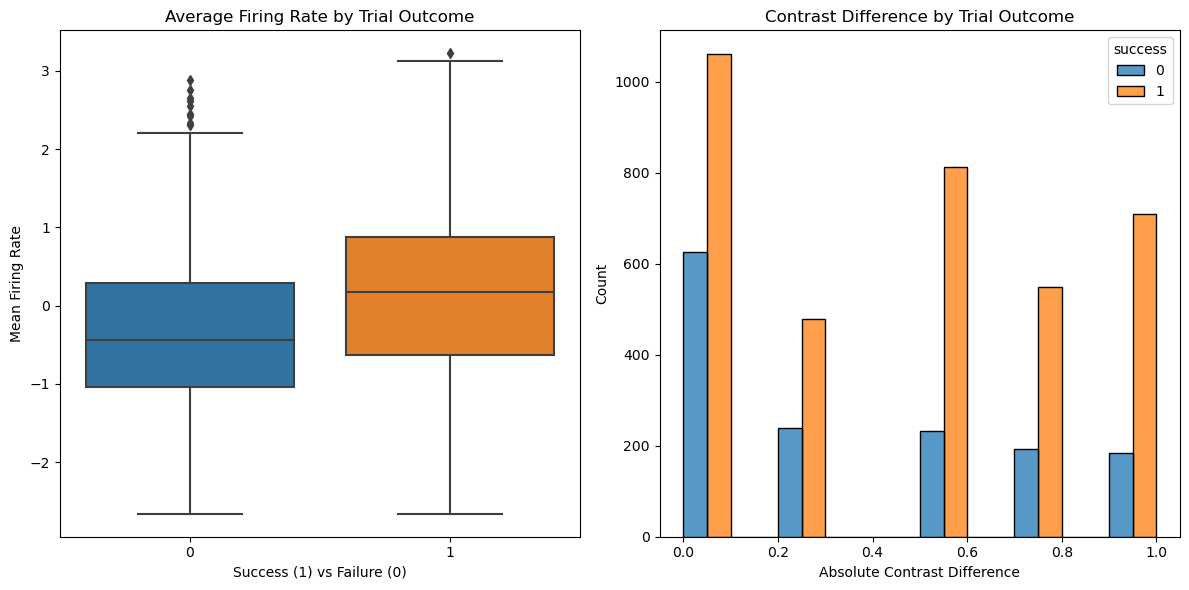

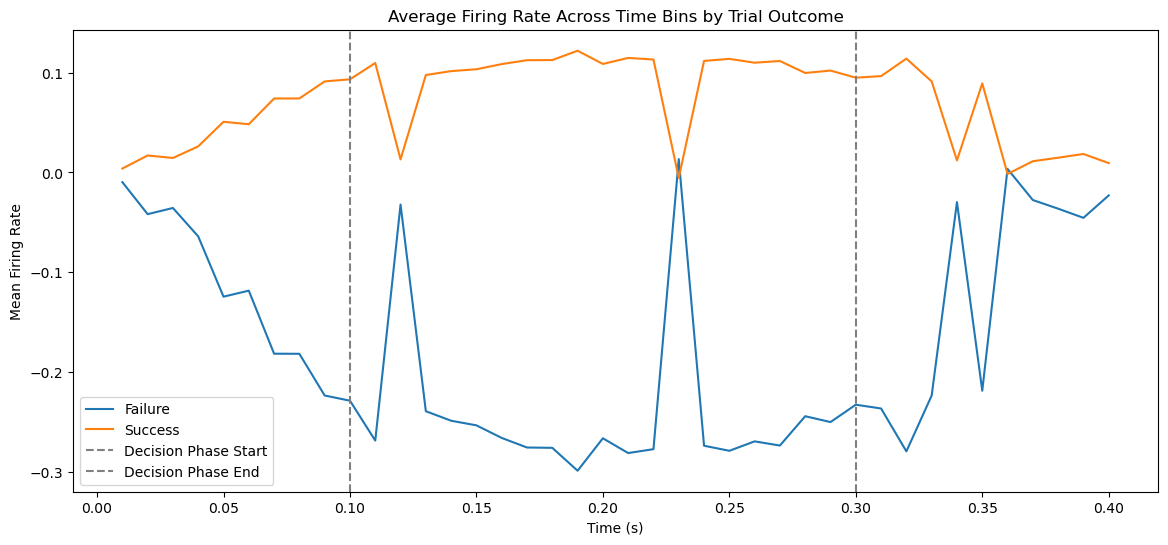

In [54]:
visualize_integrated_data(standardized_df)

## Prediction modeling

In [57]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

def perform_cross_validation(X, y, model, k=4):
    """
    Perform k-fold cross-validation and return performance metrics.
    
    Parameters:
    X : numpy array
        Feature matrix
    y : numpy array
        Target vector
    model : scikit-learn model object
        The model to evaluate
    k : int, default=4
        Number of folds for cross-validation
    
    Returns:
    dict
        Dictionary containing performance metrics
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    
    fold = 1
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Train the model
        model.fit(X_train_fold, y_train_fold)
        
        # Predict
        y_pred = model.predict(X_val_fold)
        y_prob = model.predict_proba(X_val_fold)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Compute metrics
        accuracy = accuracy_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_prob) if y_prob is not None else None
        
        # Store metrics
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        if auc is not None:
            auc_scores.append(auc)
        
        print(f"Fold {fold}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}, AUC={auc:.4f}" if auc is not None else f"Fold {fold}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1={f1:.4f}")
        fold += 1
    
    # Compute averages
    avg_metrics = {
        'avg_accuracy': np.mean(accuracy_scores),
        'avg_precision': np.mean(precision_scores),
        'avg_recall': np.mean(recall_scores),
        'avg_f1': np.mean(f1_scores),
        'avg_auc': np.mean(auc_scores) if auc_scores else None
    }
    
    print(f"\nAverage Metrics: {avg_metrics}")
    
    return avg_metrics


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_recall_curve
import xgboost as xgb
import statsmodels.api as sm

In [61]:
X_train = np.load('X_train.npy', allow_pickle=True)
X_test = np.load('X_test.npy', allow_pickle=True)
y_train = np.load('y_train.npy', allow_pickle=True)
y_test = np.load('y_test.npy', allow_pickle=True)

### Model A: Logistic regression on average spikes per neuron

In [63]:
# Logistic Regression
log_reg = LogisticRegression()
log_reg_results = perform_cross_validation(X_train, y_train, log_reg, k=4)

Fold 1: Accuracy=0.7116, Precision=0.7282, Recall=0.9427, F1=0.8217, AUC=0.7093
Fold 2: Accuracy=0.7234, Precision=0.7390, Recall=0.9385, F1=0.8269, AUC=0.7119
Fold 3: Accuracy=0.7077, Precision=0.7333, Recall=0.9141, F1=0.8138, AUC=0.6827
Fold 4: Accuracy=0.7067, Precision=0.7605, Recall=0.8750, F1=0.8137, AUC=0.6756

Average Metrics: {'avg_accuracy': 0.7123523622047244, 'avg_precision': 0.7402473689929292, 'avg_recall': 0.9175708689178474, 'avg_f1': 0.8190186542321514, 'avg_auc': 0.6948848398486625}


C:\Users\arshi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\arshi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [65]:
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import KFold

# Function to perform k-fold cross-validation for Logistic Regression
def logistic_regression_cross_val(X, y, k=4):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracy_scores = []
    auc_scores = []
    coefs = []
    
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # Standard Logistic Regression using scikit-learn
        log_reg = LogisticRegression(class_weight="balanced")
        log_reg.fit(X_train_fold, y_train_fold)
        y_pred = log_reg.predict(X_val_fold)
        y_prob = log_reg.predict_proba(X_val_fold)[:, 1]
        
        # Compute Metrics
        accuracy = accuracy_score(y_val_fold, y_pred)
        auc = roc_auc_score(y_val_fold, y_prob)
        accuracy_scores.append(accuracy)
        auc_scores.append(auc)
        
        # Store Coefficients
        coefs.append(log_reg.coef_[0])
    
    # Convert coefficient list to numpy array
    coefs = np.array(coefs)
    
    print(f"\nAverage Accuracy: {np.mean(accuracy_scores):.4f}")
    print(f"Average AUC Score: {np.mean(auc_scores):.4f}")
    
    return np.mean(accuracy_scores), np.mean(auc_scores), coefs

# Perform cross-validation
log_reg_accuracy, log_reg_auc, log_reg_coefs = logistic_regression_cross_val(X_train, y_train)

# Compute Parameter Estimates & Standard Errors Using Statsmodels
X_train_sm = sm.add_constant(X_train.astype(float))  # Add intercept
X_train_sm = np.nan_to_num(X_train_sm, nan=np.nanmean(X_train_sm))  # Handle NaN
logit_model = sm.Logit(y_train, X_train_sm).fit()

# Print Logistic Regression Summary
print(logit_model.summary())

# Extract Coefficients & P-values
print(f"Coefficients: {logit_model.params}")
print(f"P-values: {logit_model.pvalues}")

# Final Model Evaluation on Test Data
log_reg_final = LogisticRegression()
log_reg_final.fit(X_train, y_train)
y_pred_final = log_reg_final.predict(X_test)
y_prob_final = log_reg_final.predict_proba(X_test)[:, 1]

# Confusion Matrix & Misclassification Error
conf_matrix_final = confusion_matrix(y_test, y_pred_final)
error_rate_final = 1 - accuracy_score(y_test, y_pred_final)
auc_final = roc_auc_score(y_test, y_prob_final)

print(f"\nFinal Confusion Matrix:\n{conf_matrix_final}")
print(f"Final Misclassification Error Rate: {error_rate_final:.4f}")
print(f"Final AUC Score: {auc_final:.4f}")

C:\Users\arshi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\arshi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_


Average Accuracy: 0.6346
Average AUC Score: 0.6955
Optimization terminated successfully.
         Current function value: 0.538815
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 4064
Model:                          Logit   Df Residuals:                     4008
Method:                           MLE   Df Model:                           55
Date:                Mon, 17 Mar 2025   Pseudo R-squ.:                  0.1053
Time:                        06:00:11   Log-Likelihood:                -2189.7
converged:                       True   LL-Null:                       -2447.5
Covariance Type:            nonrobust   LLR p-value:                 4.658e-76
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8357        nan        nan        nan  

C:\Users\arshi\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### MODEL B: XGBoost on Spike Rate Per Time Bin

In [68]:
from xgboost import XGBClassifier

# XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_results = perform_cross_validation(X_train, y_train, xgb_model, k=4)

# Fit model
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Confusion matrix & misclassification error rate
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
error_rate_xgb = 1 - accuracy_score(y_test, y_pred_xgb)

print(f"Confusion Matrix (XGBoost):\n{conf_matrix_xgb}")
print(f"Misclassification Error Rate (XGBoost): {error_rate_xgb:.4f}")

# AUC score
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"AUC Score (XGBoost): {auc_xgb:.4f}")

C:\Users\arshi\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold 1: Accuracy=0.7185, Precision=0.7488, Recall=0.9036, F1=0.8190, AUC=0.7089
Fold 2: Accuracy=0.7057, Precision=0.7402, Recall=0.8965, F1=0.8109, AUC=0.6732
Fold 3: Accuracy=0.6683, Precision=0.7250, Recall=0.8465, F1=0.7810, AUC=0.6688
Fold 4: Accuracy=0.6998, Precision=0.7598, Recall=0.8629, F1=0.8081, AUC=0.6662

Average Metrics: {'avg_accuracy': 0.6980807086614172, 'avg_precision': 0.7434401267230983, 'avg_recall': 0.8773792201163965, 'avg_f1': 0.8047371383940881, 'avg_auc': 0.6792560030534855}
Confusion Matrix (XGBoost):
[[ 68 226]
 [ 75 648]]
Misclassification Error Rate (XGBoost): 0.2960
AUC Score (XGBoost): 0.6905


### Model C: predicting feedback using KNN

In [71]:
from sklearn.neighbors import KNeighborsClassifier

# KNN Model
knn_model = KNeighborsClassifier(n_neighbors=19)
knn_results = perform_cross_validation(X_train, y_train, knn_model, k=4)

# Fit model
knn_model.fit(X_train, y_train)

# Predict on test data
y_pred_knn = knn_model.predict(X_test)
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]

# Confusion matrix & misclassification error rate
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
error_rate_knn = 1 - accuracy_score(y_test, y_pred_knn)

print(f"Confusion Matrix (KNN):\n{conf_matrix_knn}")
print(f"Misclassification Error Rate (KNN): {error_rate_knn:.4f}")

# AUC score
auc_knn = roc_auc_score(y_test, y_prob_knn)
print(f"AUC Score (KNN): {auc_knn:.4f}")

Fold 1: Accuracy=0.6929, Precision=0.7149, Recall=0.9385, F1=0.8116, AUC=0.6372
Fold 2: Accuracy=0.6919, Precision=0.7166, Recall=0.9301, F1=0.8095, AUC=0.6492
Fold 3: Accuracy=0.6880, Precision=0.7181, Recall=0.9113, F1=0.8032, AUC=0.6325
Fold 4: Accuracy=0.6969, Precision=0.7433, Recall=0.8952, F1=0.8122, AUC=0.6402

Average Metrics: {'avg_accuracy': 0.6924212598425197, 'avg_precision': 0.723220756506239, 'avg_recall': 0.9187615780149583, 'avg_f1': 0.8091279900502485, 'avg_auc': 0.6398019231935539}
Confusion Matrix (KNN):
[[ 44 250]
 [ 50 673]]
Misclassification Error Rate (KNN): 0.2950
AUC Score (KNN): 0.6407


### Random Forest

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [76]:
# Step 1: Define Hyperparameter Grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [5, 10, 15],  # Tree depth
    'min_samples_split': [2, 5],  # Minimum samples to split
    'min_samples_leaf': [1, 2]  # Minimum samples per leaf
}

In [78]:
# Step 2: Initialize the Random Forest Model
rf = RandomForestClassifier(random_state=42)

In [80]:
# Step 3: Perform Grid Search Cross-Validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [82]:
# Step 4: Get Best Parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [84]:
# Step 5: Train Random Forest with Best Parameters
rf_best = RandomForestClassifier(**best_params, random_state=42)

In [86]:
# Step 6: Perform k-fold cross-validation on the ENTIRE dataset with your custom function
X = np.vstack((X_train, X_test))  # Combine train and test data
y = np.concatenate((y_train, y_test))  # Combine train and test labels
cv_metrics = perform_cross_validation(X, y, rf_best, k=4)

Fold 1: Accuracy=0.7183, Precision=0.7182, Recall=0.9831, F1=0.8300, AUC=0.7050
Fold 2: Accuracy=0.7236, Precision=0.7250, Recall=0.9799, F1=0.8334, AUC=0.7220
Fold 3: Accuracy=0.7378, Precision=0.7386, Recall=0.9813, F1=0.8429, AUC=0.6993
Fold 4: Accuracy=0.7244, Precision=0.7356, Recall=0.9628, F1=0.8340, AUC=0.6783

Average Metrics: {'avg_accuracy': 0.7260396984208602, 'avg_precision': 0.7293429676167389, 'avg_recall': 0.9767791590376467, 'avg_f1': 0.8350595442380971, 'avg_auc': 0.7011512412782382}


In [88]:
# Step 7: Train final model on all training data for testing purposes
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)

In [90]:
# Step 8: Make Predictions on test set
y_pred_rf = rf_best.predict(X_test)

In [92]:
# Step 9: Evaluate Performance on test set
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)
misclassification_error_rf = 1 - accuracy_rf  # Misclassification error
print(f"\nFinal Test Set Performance:")
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest AUC Score: {auc_rf:.4f}")
print(f"Random Forest Misclassification Error: {misclassification_error_rf:.4f}")
print(f"Confusion Matrix:\n{conf_matrix_rf}")


Final Test Set Performance:
Random Forest Accuracy: 0.7316
Random Forest AUC Score: 0.5478
Random Forest Misclassification Error: 0.2684
Confusion Matrix:
[[ 33 261]
 [ 12 711]]


In [94]:
# Step 10: Detailed Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.11      0.19       294
           1       0.73      0.98      0.84       723

    accuracy                           0.73      1017
   macro avg       0.73      0.55      0.52      1017
weighted avg       0.73      0.73      0.65      1017



In [122]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, f1_score, log_loss, brier_score_loss

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of positive class

    results = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'AUC Score': roc_auc_score(y_test, y_prob),
        'F1 Score': f1_score(y_test, y_pred),
        'Log Loss': log_loss(y_test, y_prob),
        'Brier Score': brier_score_loss(y_test, y_prob)
    }
    
    return results

In [124]:
# Evaluate Logistic Regression model
log_reg_results = evaluate_model(log_reg_final, X_test, y_test)

# Print the results
print("\nLogistic Regression Model Evaluation:")
for metric, value in log_reg_results.items():
    print(f"{metric}: {value:.4f}")


Logistic Regression Model Evaluation:
Accuracy: 0.7070
AUC Score: 0.6877
F1 Score: 0.8176
Log Loss: 0.5575
Brier Score: 0.1891


### test data

In [167]:
import os
import numpy as np
import pandas as pd
import rpy2.robjects as robjects
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Define test data path
test_data_path = r"C:\Users\arshi\OneDrive\Desktop\Soha\STA 141A\STA 141A project\Test Data"

# Function to read RDS file
def read_rds(file_path):
    readRDS = robjects.r['readRDS']
    return readRDS(file_path)

In [169]:
# Load test data files
test_sessions = []
for test_file in ['test1.rds', 'test2.rds']:
    file_path = os.path.join(test_data_path, test_file)
    test_sessions.append(read_rds(file_path))

In [171]:
# Process the test data using your predefined functions
# Create unified dataset
test_unified_df = create_unified_dataset(test_sessions)
print(f"Unified test dataset shape: {test_unified_df.shape}")

Unified test dataset shape: (200, 53)


In [173]:
# Apply feature engineering
test_engineered_df = engineer_features(test_unified_df)
print(f"Engineered test dataset shape: {test_engineered_df.shape}")

Engineered test dataset shape: (200, 60)


In [175]:
# Apply standardization
test_standardized_df = standardize_features(test_engineered_df)
print(f"Standardized test dataset shape: {test_standardized_df.shape}")

Standardized test dataset shape: (200, 60)


In [177]:
# Prepare test data for model prediction
# Since we're not splitting the test data, we'll modify the prepare_final_datasets function
def prepare_test_dataset(df):
    """
    Prepare test dataset for prediction by removing non-feature columns.
    """
    # Columns to drop (non-feature columns)
    cols_to_drop = ['session_id', 'trial_id', 'date_exp']
    
    # Extract the target variable
    y_test = df['success']
    
    # Drop non-feature columns and target variable
    X_test = df.drop(cols_to_drop + ['success', 'feedback_type'], axis=1)
    
    return X_test, y_test

In [179]:
# Prepare test dataset
X_test_external, y_test_external = prepare_test_dataset(test_standardized_df)
print(f"External test features shape: {X_test_external.shape}")
print(f"External test target shape: {y_test_external.shape}")

External test features shape: (200, 55)
External test target shape: (200,)


In [186]:
# Check if test data is loaded
print(test_standardized_df.head())  # Preview the first few rows
print(test_standardized_df.columns)  # Check column names

   session_id  trial_id    date_exp  contrast_left  contrast_right  \
0           1         1  2016-12-14           0.25            0.25   
1           1         2  2016-12-14           0.00            0.00   
2           1         3  2016-12-14           1.00            0.50   
3           1         4  2016-12-14           0.00            0.50   
4           1         5  2016-12-14           1.00            0.50   

   contrast_diff  feedback_type  success  mean_firing_rate  \
0            0.0           -1.0        0         -0.328313   
1            0.0            1.0        1          0.114888   
2            0.5            1.0        1          1.301681   
3            0.5            1.0        1          1.109627   
4            0.5            1.0        1          0.228150   

   decision_phase_rate  ...  time_bin_39  time_bin_40  firing_rate_slope  \
0            -0.465789  ...    -0.521677    -0.813309          -0.165603   
1             0.088214  ...    -1.704617    -1.079532 

In [202]:
# For your test data processing
def prepare_test_dataset(test_df, feature_names):
    """
    Prepare test dataset with the same features as training data.
    """
    # Process test data 
    test_df = engineer_features(test_df)
    test_df = standardize_features(test_df)
    
    # Extract target
    y_test = test_df['success'] if 'success' in test_df.columns else None
    
    # Drop non-feature columns
    test_df = test_df.drop(['session_id', 'trial_id', 'date_exp', 'feedback_type', 'success'], axis=1, errors='ignore')
    
    # Ensure all required features are present
    for feature in feature_names:
        if feature not in test_df.columns:
            test_df[feature] = 0  # Add missing columns with default value
    
    # Keep only the features used in training
    X_test = test_df[feature_names].values
    
    return X_test, y_test

# When processing test data:
X_test_external, y_test_external = prepare_test_dataset(test_unified_df, feature_names)

In [204]:
# Now that your test data is correctly formatted, make predictions
y_pred_rf = rf_best.predict(X_test_external)

# Get prediction probabilities (optional)
y_pred_proba_rf = rf_best.predict_proba(X_test_external)

# If you have ground truth labels for test data, evaluate performance
if y_test_external is not None:
    # Calculate accuracy
    accuracy = accuracy_score(y_test_external, y_pred_rf)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(y_test_external, y_pred_rf)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate AUC-ROC if applicable
    if y_pred_proba_rf is not None and len(np.unique(y_test_external)) == 2:
        auc_roc = roc_auc_score(y_test_external, y_pred_proba_rf[:, 1])
        print(f"AUC-ROC: {auc_roc:.4f}")

Test accuracy: 0.7200
Confusion Matrix:
[[  5  50]
 [  6 139]]
AUC-ROC: 0.7240
